In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms.functional as F
from torchvision.models import ViT_B_32_Weights, vit_b_32

from wings.config import IMG_FOLDER_SUFX
from wings.config import MODELS_DIR
from wings.config import RAW_DATA_DIR, COORDS_SUFX, PROJ_ROOT
from wings.modeling.litnet import LitNet
from wings.modeling.models import TransformerPreTrained

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def preprocess(img: torch.Tensor) -> torch.Tensor:
    img = F.resize(img, [224, 224], interpolation=F.InterpolationMode.BILINEAR, antialias=True)
    # img = F.center_crop(img, self.crop_size)
    if not isinstance(img, torch.Tensor):
        img = F.pil_to_tensor(img)
    img = F.convert_image_dtype(img, torch.float)
    img = F.normalize(img, mean=mean, std=std)
    return img


def denormalize(img: torch.Tensor) -> torch.Tensor:
    mean_d = torch.tensor(mean).view(3, 1, 1)
    std_d = torch.tensor(std).view(3, 1, 1)
    img = img * std_d + mean_d
    img = img.numpy().transpose(1, 2, 0)
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    img = np.ascontiguousarray(img)
    return img


In [20]:
def plt_imshow(img, img_title="image"):
    plt.figure()
    plt.title(img_title)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis("off")
    plt.show()


def visualize_from_file(filename, data_folder=RAW_DATA_DIR):
    country = filename.split('-', 1)[0]
    imgpath = data_folder / f"{country}{IMG_FOLDER_SUFX}" / filename
    img = cv2.imread(imgpath, cv2.IMREAD_COLOR)

    df = pd.read_csv(data_folder / f"{country}{COORDS_SUFX}")
    row = df[df['file'] == filename].iloc[0]

    targets = pd.to_numeric(row.iloc[1:].values)
    targets = torch.tensor(targets, dtype=torch.float32)

    visualize_coords(img, targets, filename=filename)


def visualize_coords(img, targets, *, filename=None, spot_size=6, save_path=None):
    x_size, y_size = img.shape[1], img.shape[0]
    x_coords, y_coords = targets[::2], targets[1::2]
    y_coords = y_size - y_coords

    for x, y in zip(x_coords, y_coords):
        x, y = int(x), int(y)
        cv2.circle(img, (x, y), spot_size, (0, 255, 0), -1)

    plt_imshow(img, filename)

In [21]:
test_dataset = torch.load(PROJ_ROOT / "test_dataset-transformer-v03.pth", weights_only=False)

In [22]:
checkpoint_path = MODELS_DIR / 'transformer_pretrained_v03.ckpt'
weights = ViT_B_32_Weights.DEFAULT
transformer_model = TransformerPreTrained(vit_b_32, weights)

num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=transformer_model, num_epochs=num_epochs)
model.eval()

max_n = len(test_dataset)

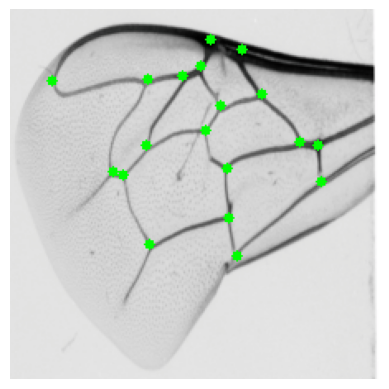

In [73]:
n = np.random.randint(0, max_n)
image, label = test_dataset[n]
labels = model(image.cuda().unsqueeze(0))
image = denormalize(image)
visualize_coords(image, labels.squeeze(0), spot_size=3)